In [18]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class Config():
    training_dir = "/content/drive/MyDrive/training"
    testing_dir = "/content/drive/MyDrive/testing"
    train_batch_size = 64
    train_number_epochs = 100




In [15]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=False):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0_path = img0_tuple[0]
        img1_path = img1_tuple[0]

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), img0_path, img1_path
        # 두 이미지가 서로 다른 클래스면 1
        # 두 이미지가 서로 같은 클래스면 0

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


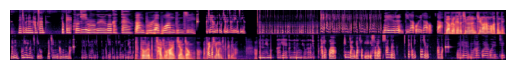

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((99,250)),transforms.ToTensor()])
                                       ,should_invert=False)


vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated)) # 여러 개 이미지 합쳐서 grid로 반환
print(example_batch[2].numpy()) # 두 이미지가 같은 클래스인지에 대한 label

In [7]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1), # 가장자리의 특징들까지 고려
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*99*250, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # flatten
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [8]:
class ContrastiveLoss(torch.nn.Module):
                                    # margin : 클래스가 다른 두 샘플 간의 최소한의 거리 값. 클래스가 다른 두 샘플간의 거리가 margin 이상이 되도록 학습.
    def __init__(self, margin=2.0): # 서로 class가 다를 때, margin값을 기준으로 두 이미지 간의 거리를 조절. 두 이미지 사이의 거리가 margin값보다 클 때 까지 손실이 발생
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        # print(f"label : {label}, distance : {euclidean_distance}")

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + # 같은 클래스 쌍에 대한 손실
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # 다른 클래스 쌍에 대한 손실

        return loss_contrastive

Epoch number 0
 Current loss 1.6219837665557861

Epoch number 1
 Current loss 39.648277282714844

Epoch number 2
 Current loss 11.8264799118042

Epoch number 3
 Current loss 11.300661087036133

Epoch number 4
 Current loss 10.121405601501465

Epoch number 5
 Current loss 5.420836448669434

Epoch number 6
 Current loss 2.589258909225464

Epoch number 7
 Current loss 2.8571653366088867

Epoch number 8
 Current loss 1.5104310512542725

Epoch number 9
 Current loss 1.5068845748901367

Epoch number 10
 Current loss 1.2341973781585693

Epoch number 11
 Current loss 0.5222157835960388

Epoch number 12
 Current loss 0.7455909252166748

Epoch number 13
 Current loss 0.5088977813720703

Epoch number 14
 Current loss 0.2611287832260132

Epoch number 15
 Current loss 0.28019261360168457

Epoch number 16
 Current loss 0.24796755611896515

Epoch number 17
 Current loss 0.15334388613700867

Epoch number 18
 Current loss 0.16330325603485107

Epoch number 19
 Current loss 0.17206987738609314

Epoch num

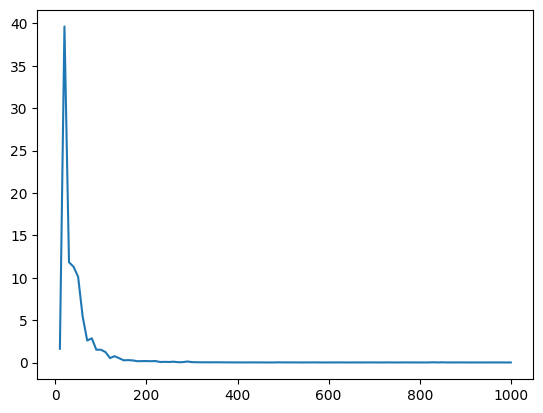

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )


counter = []
loss_history = []
iteration_number= 0


for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [11]:
print(loss_history[-1])

0.005426520481705666


In [12]:
torch.save(net,'siamese_net_v4.pt')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("siamese_net_v4.pt", map_location=device)
print(model)

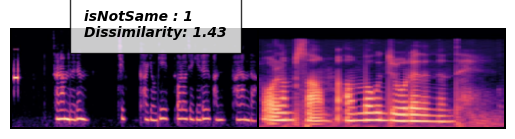

left img's name : Mel_spectrum_VAD_12290-F-3-JA-B-LAR019-2672236.jpg',)
right img's name : Mel_spectrum_VAD_KsponSpeech_000098.jpg',)


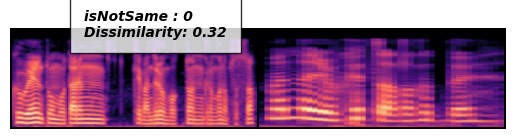

left img's name : Mel_spectrum_VAD_KsponSpeech_000092.jpg',)
right img's name : Mel_spectrum_VAD_KsponSpeech_000100.jpg',)


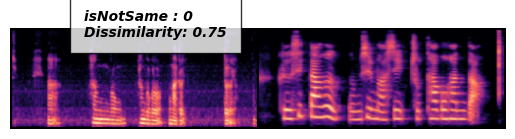

left img's name : Mel_spectrum_VAD_01404-M-89-EN-B-ATQ008-0307256.jpg',)
right img's name : Mel_spectrum_VAD_12374-F-98-ZH-A-LAR012-2693954.jpg',)


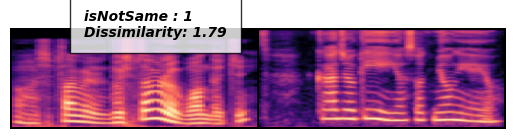

left img's name : Mel_spectrum_VAD_KsponSpeech_000093.jpg',)
right img's name : Mel_spectrum_VAD_01229-F-97-EN-B-ATQ004-1031744.jpg',)


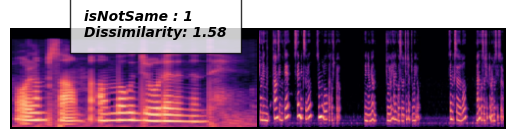

left img's name : Mel_spectrum_VAD_KsponSpeech_000098.jpg',)
right img's name : Mel_spectrum_VAD_01143-F-97-EN-A-ATQ027-0799568.jpg',)


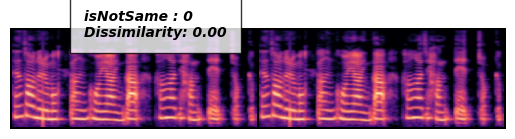

left img's name : Mel_spectrum_VAD_12297-F-1-JA-B-LAR022-2674776.jpg',)
right img's name : Mel_spectrum_VAD_12297-F-1-JA-B-LAR022-2674776.jpg',)


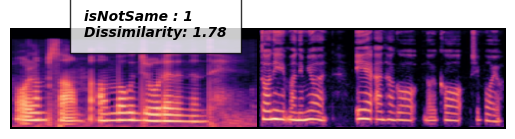

left img's name : Mel_spectrum_VAD_KsponSpeech_000098.jpg',)
right img's name : Mel_spectrum_VAD_01229-F-97-EN-B-ATQ019-1031898.jpg',)


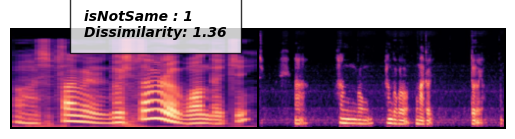

left img's name : Mel_spectrum_VAD_KsponSpeech_000093.jpg',)
right img's name : Mel_spectrum_VAD_01404-M-89-EN-B-ATQ008-0307256.jpg',)


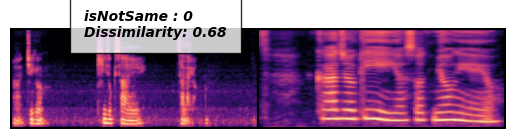

left img's name : Mel_spectrum_VAD_01404-M-89-EN-B-ATQ007-0307254.jpg',)
right img's name : Mel_spectrum_VAD_01229-F-97-EN-B-ATQ004-1031744.jpg',)


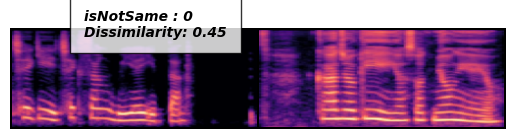

left img's name : Mel_spectrum_VAD_12820-F-2-ZH-A-LAR002-2875027.jpg',)
right img's name : Mel_spectrum_VAD_01229-F-97-EN-B-ATQ004-1031744.jpg',)


In [22]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((99,250)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=1,batch_size=1,shuffle=True) # 1장씩 test


dataiter = iter(test_dataloader)
# x0,x1,label1 = next(dataiter) # test의 기준이 되는 img.
# 0 : same class , 1 : other class

for i in range(10):
    x0,x1,label1,x0_path,x1_path = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'isNotSame : {:.0f}\nDissimilarity: {:.2f}'.format(label1.item(),euclidean_distance.item()))
    print(f"left img's name : {os.path.basename(str(x0_path))}\nright img's name : {os.path.basename(str(x1_path))}")

In [ ]:
def compute_accuracy(model, test_loader, threshold=1.0): # margin 1.0 -> 0.74
    correct = 0
    total = 0

    model.eval()  # 평가 모드로 설정

    with torch.no_grad():
        for data1, data2, labels in test_loader:

            data1, data2, labels = data1.cuda(), data2.cuda(), labels.cuda()
            output1, output2 = model(data1, data2)

            euclidean_distance = F.pairwise_distance(output1, output2)
            predicted = (euclidean_distance > threshold).float()  # 유사성을 확인하기 위한 임계값 적용
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    accuracy *= 100
    return accuracy

result = 0
for i in range(0,100):
  acc = int(compute_accuracy(net, test_dataloader))
  result += acc
print("accuracy : {}%".format(result/100))